# Multi-Stage CNN Architecture for Face Mask Detection

### Ingesting the data and adding the labels:

Importing necessary libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
import warnings
warnings.filterwarnings('ignore')

Understanding the contents on the image data:

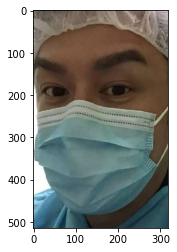

In [2]:
img = image.load_img("dataset-face-mask/dataset/train_validate/masked/0_0_0 copy 9.jpg")
plt.imshow(img)

Printing the matrix content of the same image

In [3]:
cv2.imread("dataset-face-mask/dataset/train_validate/masked/0_0_0 copy 9.jpg").shape

(514, 319, 3)

In [89]:
# generating datasets

datagen = ImageDataGenerator(rescale=1./255,
     rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2) # set validation split

train_data = datagen.flow_from_directory("dataset-face-mask/dataset/train_validate", 
                                       target_size = (64,64), 
                                      batch_size=32, shuffle=False,
                                         class_mode='binary',
                                        subset='training')
validation_data = datagen.flow_from_directory("dataset-face-mask/dataset/train_validate", 
                                       target_size = (64,64), 
                                       batch_size=32, shuffle=False,
                                              class_mode='binary',
                                             subset='validation')

Found 1382 images belonging to 2 classes.
Found 345 images belonging to 2 classes.


In [91]:
test = ImageDataGenerator(rescale=1./255,
                        rotation_range=40,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        shear_range=0.2,
                        zoom_range=0.2,
                        horizontal_flip=True)

test_data = test.flow_from_directory('dataset-face-mask/dataset/test',
                                                 batch_size=32,
                                     class_mode='binary',
                                                 shuffle=False,
                                                     target_size=(64,64))

Found 320 images belonging to 2 classes.


In [92]:
#defining the model as per specifical

"""
    Conv2D(128, (3,3), activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(2,2),
    Conv2D(64, (3,3), activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dense(1, activation='relu'),
    Dense(1, activation='softmax')
"""
model = keras.models.Sequential([
Conv2D(64,(3,3), activation='relu', input_shape=(64, 64, 3)),
MaxPooling2D(2,2),
Conv2D(64,(3,3), activation='relu'),
Conv2D(128,(3,3), padding='same', activation='relu'),
MaxPooling2D(2,2),
Flatten(),
Dense(256, activation='relu'),
Dense(1, activation='softmax')
])
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_19 (Conv2D)           (None, 62, 62, 64)        1792      
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 29, 29, 64)        36928     
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 29, 29, 128)       73856     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 14, 14, 128)       0         
_________________________________________________________________
flatten_6 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dense_12 (Dense)             (None, 256)              

In [105]:
STEP_SIZE_TRAIN=train_data.samples/train_data.batch_size
STEP_SIZE_VALID=validation_data.samples/validation_data.batch_size
model_fit = model.fit(train_data,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                                batch_size=32,
                    validation_data=validation_data,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=3
)

Epoch 1/3
43/43 [==============================] - 20s 475ms/step - loss: 0.3165 - accuracy: 0.4863 - val_loss: 0.2391 - val_accuracy: 0.4870
Epoch 2/3
43/43 [==============================] - 22s 511ms/step - loss: 0.3601 - accuracy: 0.4863 - val_loss: 0.4132 - val_accuracy: 0.4870
Epoch 3/3
43/43 [==============================] - 29s 679ms/step - loss: 0.3053 - accuracy: 0.4863 - val_loss: 0.4115 - val_accuracy: 0.4870


In [94]:
print('Final training loss \t', model_fit.history['loss'][-1]*100)
print('Final training accuracy ', model_fit.history['accuracy'][-1]*100)

Final training loss 	 67.66456961631775
Final training accuracy  49.77777898311615


In [95]:
valLoss, valAccuracy = model.evaluate(test_data, steps=STEP_SIZE_VALID)

10/10 [==============================] - 2s 161ms/step - loss: 0.6188 - accuracy: 0.5000


In [96]:
print('Validation loss ', valLoss)
print('Validation accuracy ', valAccuracy)

Validation loss  0.6187856793403625
Validation accuracy  0.5


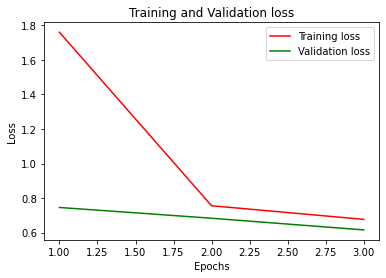

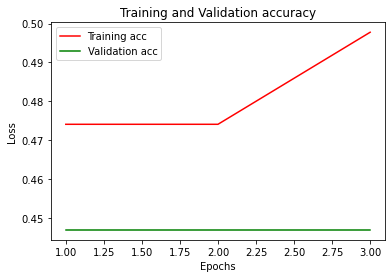

In [97]:
# plotting training and validation loss

loss = model_fit.history['loss']
val_loss = model_fit.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, color='green', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# plotting training and validation accuracy

acc = model_fit.history['accuracy']
val_acc = model_fit.history['val_accuracy']
plt.plot(epochs, acc, color='red', label='Training acc')
plt.plot(epochs, val_acc, color='green', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [98]:
# validating the model
test_data.reset()
test_loss, test_accuracy = model.evaluate(test_data, verbose=1)

10/10 [==============================] - 2s 160ms/step - loss: 0.6217 - accuracy: 0.5000


In [99]:
print('Test loss ', test_loss)
print('Test accuracy ', test_accuracy)

Test loss  0.6217361688613892
Test accuracy  0.5


In [100]:
from sklearn.metrics import classification_report, confusion_matrix
m_pred = model.predict_generator(test_data, steps=10)
Y_pred = np.argmax(m_pred, axis=1)
print('Confusion Matrix')
Confusion_matrix = confusion_matrix(test_data.classes, Y_pred)
print(Confusion_matrix)

Confusion Matrix
[[160   0]
 [160   0]]


In [46]:
m_pred

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],

In [41]:
test_data.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [42]:
Y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [83]:
# Classification Report

from sklearn.metrics import classification_report 

print(classification_report(test_data.classes, Y_pred, target_names = ['without mask', 'with mask']))

              precision    recall  f1-score   support

without mask       0.50      1.00      0.67       160
   with mask       0.00      0.00      0.00       160

    accuracy                           0.50       320
   macro avg       0.25      0.50      0.33       320
weighted avg       0.25      0.50      0.33       320



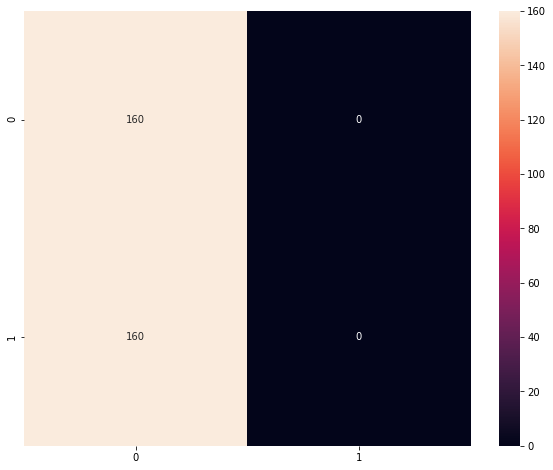

In [14]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

# compute the confusion matrix
#confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

plt.figure(figsize=(10,8))
sns.heatmap(Confusion_matrix, annot=True, fmt="d");

### Generating a model that perform better

In [15]:
#making changes to improve model accuracy
improved_model = keras.models.Sequential([
    Conv2D(16, 3, activation='relu', input_shape=(64, 64, 3)),
    MaxPooling2D(2,2),
    Conv2D(32, 3, activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(64, 3, activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(128, 3, activation='relu'),
    MaxPooling2D(2,2),
    Conv2D(256, 3, padding='same', activation='relu'),
    MaxPooling2D(2,2),
    Flatten(),
    Dropout(0.3), 
    Dense(256, activation='relu'),
    Dense(1, activation='softmax') # dense layer has a shape of 2 as we have only 2 classes 
])
improved_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [16]:
improved_model_fit = improved_model.fit(train_data, epochs=50, validation_data = validation_data)

Epoch 1/50
44/44 [==============================] - 12s 255ms/step - loss: 0.7107 - accuracy: 0.5451 - val_loss: 0.6922 - val_accuracy: 0.4870
Epoch 2/50
44/44 [==============================] - 9s 204ms/step - loss: 0.6896 - accuracy: 0.3699 - val_loss: 0.5925 - val_accuracy: 0.4870
Epoch 3/50
44/44 [==============================] - 9s 196ms/step - loss: 0.6375 - accuracy: 0.4718 - val_loss: 0.5252 - val_accuracy: 0.4870
Epoch 4/50
44/44 [==============================] - 9s 207ms/step - loss: 0.4780 - accuracy: 0.4334 - val_loss: 0.4129 - val_accuracy: 0.4870
Epoch 5/50
44/44 [==============================] - 9s 194ms/step - loss: 0.4632 - accuracy: 0.4827 - val_loss: 0.4075 - val_accuracy: 0.4870
Epoch 6/50
44/44 [==============================] - 9s 201ms/step - loss: 0.3207 - accuracy: 0.3443 - val_loss: 0.3537 - val_accuracy: 0.4870
Epoch 7/50
44/44 [==============================] - 9s 203ms/step - loss: 0.3533 - accuracy: 0.4662 - val_loss: 0.2375 - val_accuracy: 0.4870
Epoch

In [17]:
print('Final training loss \t', improved_model_fit.history['loss'][-1]*100)
print('Final training accuracy ', improved_model_fit.history['accuracy'][-1]*100)

Final training loss 	 15.87357223033905
Final training accuracy  48.62518012523651


In [18]:
# validating the model
imp_model_val_loss, imp_model_val_accuracy = improved_model.evaluate( validation_data)

11/11 [==============================] - 1s 83ms/step - loss: 0.1347 - accuracy: 0.4870


In [19]:
print('Validation loss ', imp_model_val_loss)
print('Validation accuracy ', imp_model_val_accuracy)

Validation loss  0.1346883773803711
Validation accuracy  0.48695650696754456


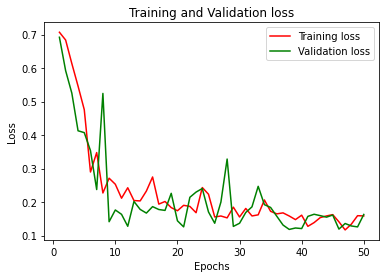

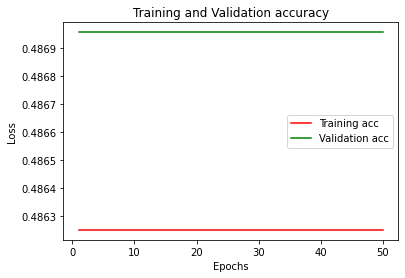

In [20]:
# plotting training and validation loss

loss = improved_model_fit.history['loss']
val_loss = improved_model_fit.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, color='red', label='Training loss')
plt.plot(epochs, val_loss, color='green', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# plotting training and validation accuracy

acc = improved_model_fit.history['accuracy']
val_acc = improved_model_fit.history['val_accuracy']
plt.plot(epochs, acc, color='red', label='Training acc')
plt.plot(epochs, val_acc, color='green', label='Validation acc')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [31]:
# validating the model
imp_model_test_loss, imp_model_test_accuracy = improved_model.evaluate( test_data, verbose=1)

10/10 [==============================] - 1s 129ms/step - loss: 0.5924 - accuracy: 0.5000


In [32]:
print('Test loss ', imp_model_test_loss)
print('Test accuracy ', imp_model_test_accuracy)

Test loss  0.5924228429794312
Test accuracy  0.5


In [36]:
test_data.reset()
from sklearn.metrics import classification_report, confusion_matrix
Y_pred_im_1 = improved_model.predict(test_data)
Y_pred_im = np.argmax(Y_pred_im_1, axis=1)
print('Confusion Matrix')
Confusion_matrix_im = confusion_matrix(test_data.classes, Y_pred_im)
print(Confusion_matrix_im)

Confusion Matrix
[[160   0]
 [160   0]]


In [24]:
test_data.classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [25]:
Y_pred_im

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [26]:
Y_pred_im_1

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],

In [27]:
# Classification Report

from sklearn.metrics import classification_report 

print(classification_report(test_data.classes, Y_pred_im))

              precision    recall  f1-score   support

           0       0.50      1.00      0.67       160
           1       0.00      0.00      0.00       160

    accuracy                           0.50       320
   macro avg       0.25      0.50      0.33       320
weighted avg       0.25      0.50      0.33       320



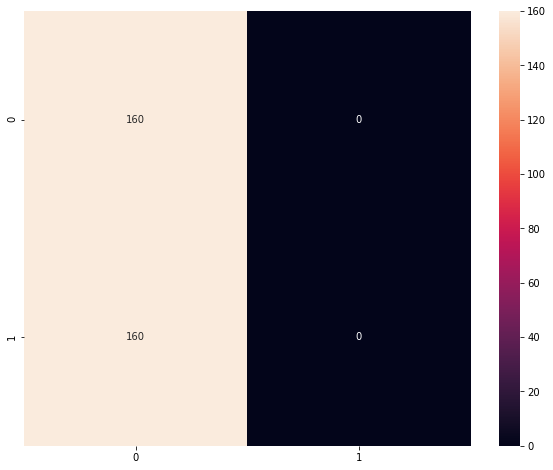

In [28]:
# confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

plt.figure(figsize=(10,8))
sns.heatmap(Confusion_matrix, annot=True, fmt="d");